<font color ='brown'>
    

    
### Load and Check Data 

In [ ]:
import numpy as np 
import pandas as pd 
import os

In [ ]:
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"theamangupta","key":"31aa643d0c0e7c8522d9732d2170db16"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp "kaggle.json" ~/.kaggle/
!cat ~/.kaggle/kaggle.json 
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri

{"username":"theamangupta","key":"31aa643d0c0e7c8522d9732d2170db16"}brain-tumor-classification-mri.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip brain-tumor-classification-mri.zip

Archive:  brain-tumor-classification-mri.zip
replace Testing/glioma_tumor/image(1).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


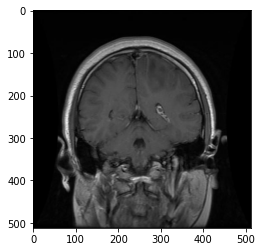

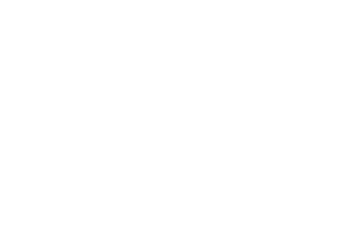

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

DATADIR = r"/content/Training/"
CATEGORIES = ["glioma_tumor","meningioma_tumor","no_tumor","pituitary_tumor"]
for category in CATEGORIES:
    path = os.path.join(DATADIR,category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))
        plt.imshow(img_array)
        plt.show()
        plt.axis("off")
        break
    break

(-0.5, 149.5, 149.5, -0.5)

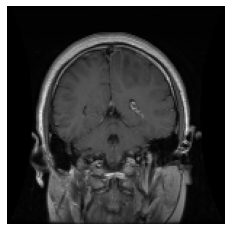

In [ ]:
IMG_SIZE = 150
new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))    
plt.imshow(new_array,cmap = "gray")
plt.axis("off")


### MANIPULATING DATA

In [ ]:
training_data = []

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR,category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE)) 
                training_data.append([new_array,class_num])
            except Exception as e:
                pass
create_training_data()

In [ ]:
X = []
y = []
for features,label in training_data:
    X.append(features)
    y.append(label)
X = np.array(X).reshape(-1,IMG_SIZE,IMG_SIZE)
print(X.shape)
X = X/255.0  
X = X.reshape(-1,150,150,1)

(2870, 150, 150)


In [ ]:
from keras.utils.np_utils import to_categorical 
y = to_categorical(y, num_classes = 4)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, y, test_size = 0.2, random_state=42)
print("x_train shape",X_train.shape)
print("x_test shape",X_val.shape)
print("y_train shape",Y_train.shape)
print("y_test shape",Y_val.shape)

x_train shape (2296, 150, 150, 1)
x_test shape (574, 150, 150, 1)
y_train shape (2296, 4)
y_test shape (574, 4)


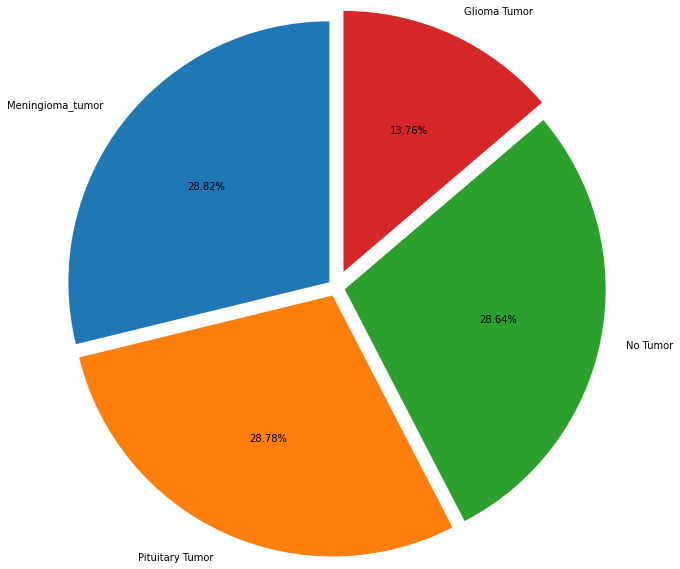

In [ ]:
plt.pie(train_data.label.value_counts(),startangle=90,explode=[0.1,0.1,0.1,0.2],autopct='%0.2f%%',
        labels=['Meningioma_tumor', 'Pituitary Tumor', 'No Tumor', 'Glioma Tumor'],radius=3)
plt.show()

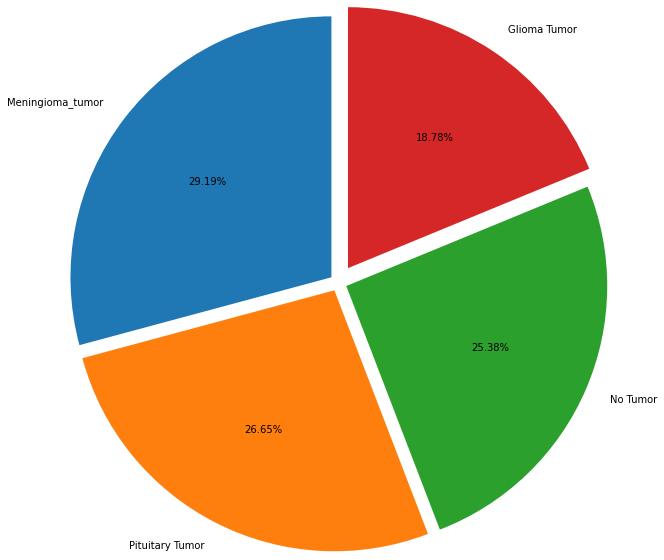

In [ ]:
plt.pie(test_data.label.value_counts(),startangle=90,explode=[0.1,0.1,0.1,0.2],autopct='%0.2f%%',
        labels=['Meningioma_tumor', 'Pituitary Tumor', 'No Tumor', 'Glioma Tumor'],radius=3)
plt.show()

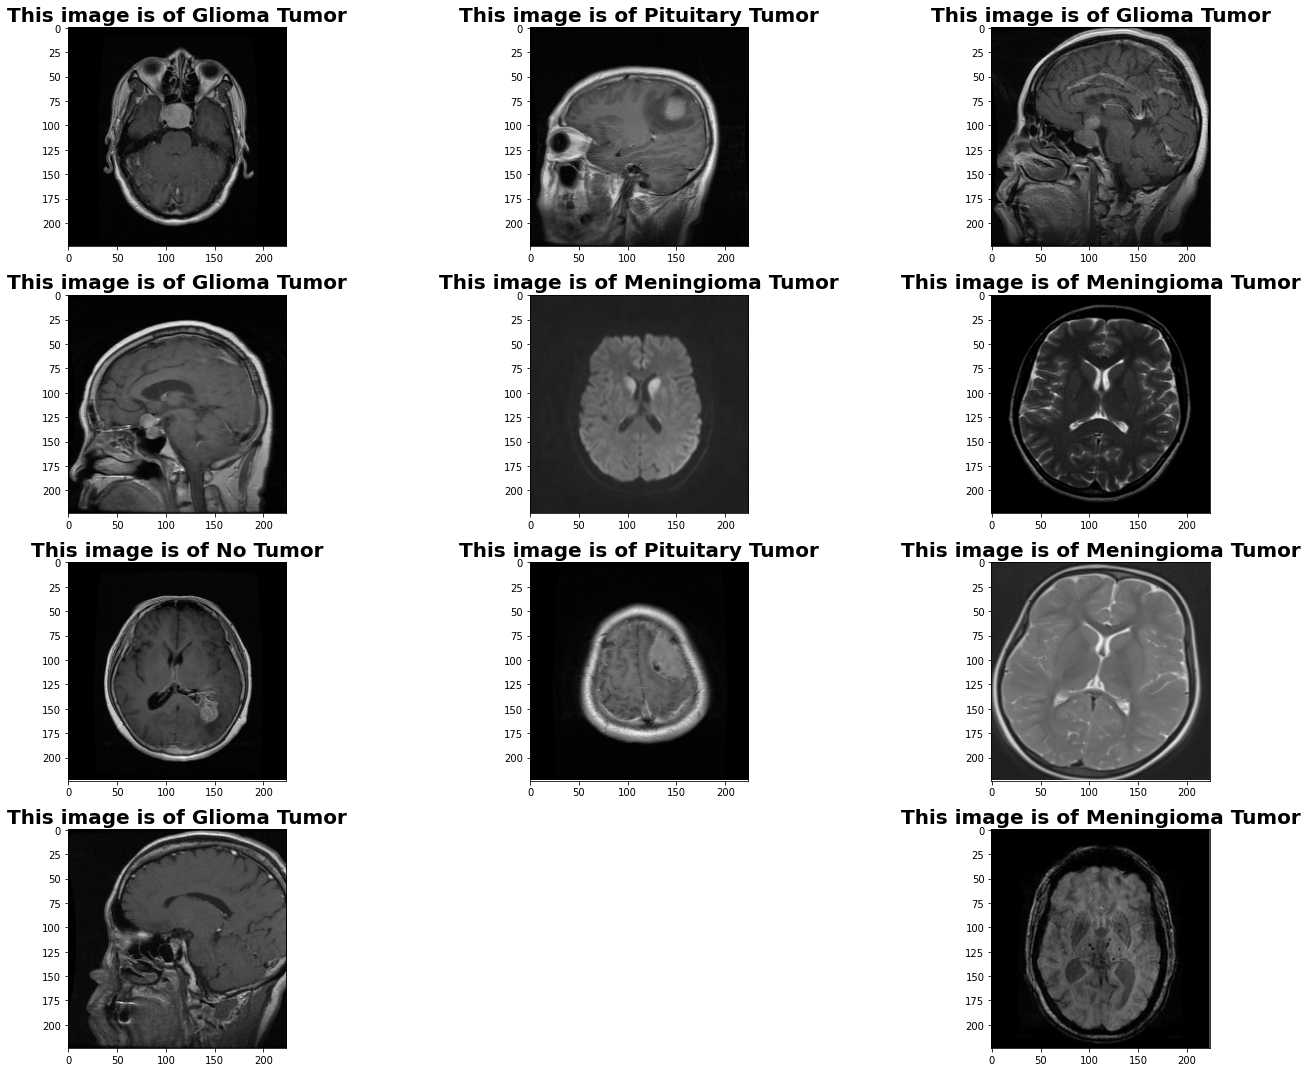

In [ ]:
plt.figure(figsize=(20,15))
for i in range(12):
    plt.subplot(4,3,(i%12)+1)
    index=np.random.randint(2000)
    plt.title('This image is of {0}'.format(inverse_classes(train_data.label[index])),fontdict={'size':20,'weight':'bold'})
    plt.imshow(train_data.image[index])
    plt.tight_layout()

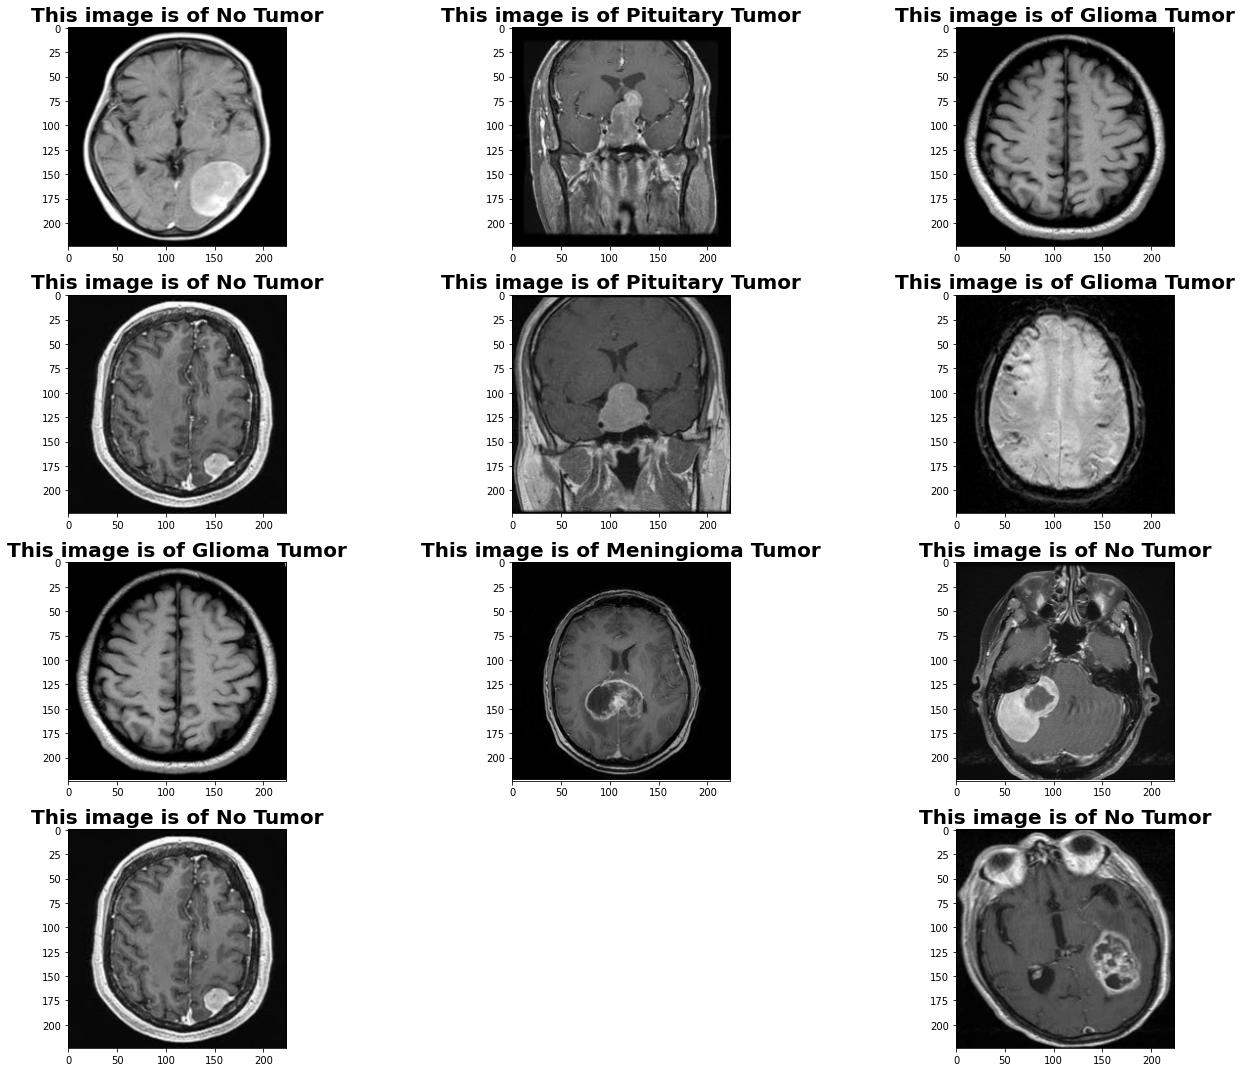

In [ ]:
plt.figure(figsize=(20,15))
for i in range(12):
    plt.subplot(4,3,(i%12)+1)
    index=np.random.randint(200)
    plt.title('This image is of {0}'.format(inverse_classes(test_data.label[index])),fontdict={'size':20,'weight':'bold'})
    plt.imshow(test_data.image[index])
    plt.tight_layout()

### PREDICTION USING CNN

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (150,150,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))


model.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))


model.add(Flatten())
model.add(Dense(1024, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(4, activation = "softmax"))
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 64)      1664      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 37, 37, 128)       0

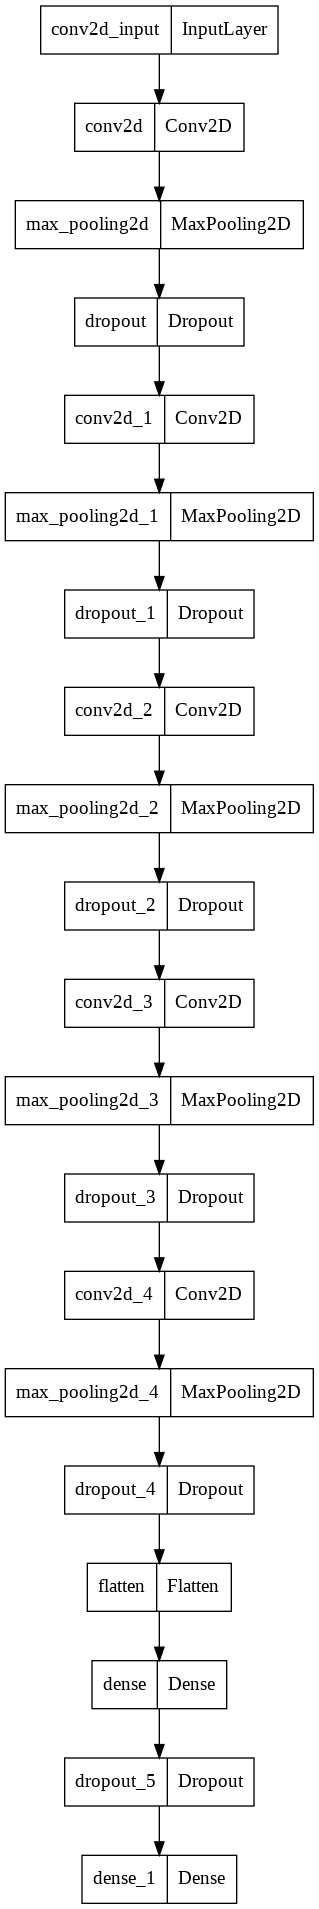

In [ ]:
plot_model(model)

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=0,
        zoom_range = 0,
        width_shift_range=0,  
        height_shift_range=0,  
        horizontal_flip=True,  
        vertical_flip=False)  


In [ ]:
epochs = 40  
batch_size = 40

In [ ]:
datagen.fit(X_train)
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              steps_per_epoch = X_train.shape[0] // batch_size)    

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


57/57 [==============================] - 285s 5s/step - loss: 1.2850 - accuracy: 0.4105 - val_loss: 1.0805 - val_accuracy: 0.5192
Epoch 2/40
57/57 [==============================] - 283s 5s/step - loss: 0.9610 - accuracy: 0.5745 - val_loss: 0.8996 - val_accuracy: 0.6411
Epoch 3/40
57/57 [==============================] - 281s 5s/step - loss: 0.8036 - accuracy: 0.6693 - val_loss: 0.7488 - val_accuracy: 0.6516
Epoch 4/40
57/57 [==============================] - 292s 5s/step - loss: 0.7375 - accuracy: 0.6981 - val_loss: 0.6715 - val_accuracy: 0.6725
Epoch 5/40
57/57 [==============================] - 276s 5s/step - loss: 0.6441 - accuracy: 0.7345 - val_loss: 0.6707 - val_accuracy: 0.6707
Epoch 6/40
57/57 [==============================] - 277s 5s/step - loss: 0.6242 - accuracy: 0.7323 - val_loss: 0.6481 - val_accuracy: 0.6916
Epoch 7/40
57/57 [==============================] - 279s 5s/step - loss: 0.5428 - accuracy: 0.7757 - val_loss: 0.5728 - val_accuracy: 0.7404
Epoch 8/40
57/57 [======

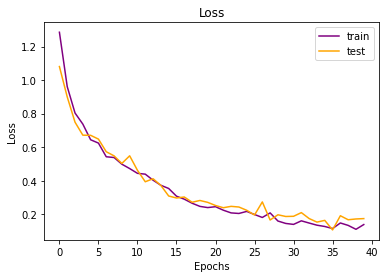

In [ ]:
plt.plot(history.history["loss"],c = "purple")
plt.plot(history.history["val_loss"],c = "orange")
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["train", "test"])
plt.show()

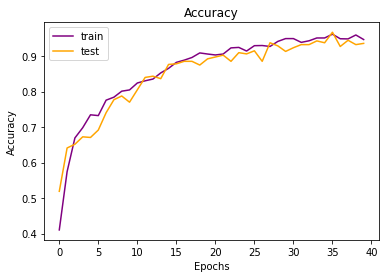

In [ ]:
plt.plot(history.history["accuracy"],c = "purple")
plt.plot(history.history["val_accuracy"],c = "orange")
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["train", "test"])
plt.show()

In [ ]:
pred = model.predict(X_val)
print(pred[0:3,:])

[[9.75836754e-01 2.39584781e-02 2.17850243e-06 2.02511248e-04]
 [1.07010501e-05 1.94278196e-03 2.64832966e-06 9.98043895e-01]
 [1.10928066e-01 8.89062583e-01 8.69121504e-06 6.80366213e-07]]


In [ ]:
temp = np.argmax(pred, axis = 1)
pred = np.zeros(pred.shape)
pred[np.arange(pred.shape[0]), temp] = 1
print(pred[0:3,:])
print(Y_val[0:3,:])

[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]]
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]]


In [ ]:
from sklearn.metrics import accuracy_score, classification_report
print('Accuracy : ' + str(accuracy_score(Y_val, pred)))
print(classification_report(Y_val, pred, target_names = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']))

Accuracy : 0.9355400696864111
                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.88      0.93       179
meningioma_tumor       0.84      0.98      0.90       169
        no_tumor       0.96      0.91      0.93        70
 pituitary_tumor       0.99      0.96      0.97       156

       micro avg       0.94      0.94      0.94       574
       macro avg       0.95      0.93      0.94       574
    weighted avg       0.94      0.94      0.94       574
     samples avg       0.94      0.94      0.94       574



In [ ]:
# serialize model to JSON
from keras.models import model_from_json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)


In [ ]:
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
json_file = open('/content/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

loaded_model.load_weights("/content/model.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
score = loaded_model.evaluate(X_val, Y_val, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

accuracy: 93.55%
